# 1d Conv on EEG data

Start with simple models
1. Linear model (LIN)
2. Multi Layer Perceptron Model (MLP)
3. Convolutional Model (CNN)

In [1]:
import sys
sys.path.append('../')

In [2]:
from utils.dataset import EEGDataset
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


eeg_dir = Path('../EEGDataset/raw')
subjects = ['sub-01']

data = EEGDataset(eeg_dir, subjects)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [3]:
def train(dataloader, model, loss_fn, optimizer, device='cpu', clip=None):
    model.train()

    tra_loss = 0
    for batch in dataloader:
        X = batch['eeg'].to(device)
        y = batch['label'].to(device)

        # compute prediction error
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        if clip is not None:
            torch.nn.utils.clip_grad_norm(model.parameters(), clip)   
        optimizer.step()

        tra_loss += loss.item() * len(batch)

    tra_loss /= len(dataloader.dataset)

    return tra_loss

def valid(dataloader, model, loss_fn, device='cpu'):
    size = len(dataloader.dataset)
    model.eval()                    # set to eval to not compute gradient

    val_loss, correct = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch['eeg'].to(device)
            y = batch['label'].to(device)

            pred = model(X).squeeze()
            val_loss += loss_fn(pred, y).item() * len(batch)
            correct += ((pred>0.5) == y).type(torch.float).sum().item()
    val_loss /= size
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")

    return val_loss     

### 1. Linear model

In [13]:
from utils.models import LIN
from utils.transforms import Compose, Flatten, ToTensor 
from torch.utils.data import random_split, DataLoader 

# Training parameters
batch_size = 32
lr = 3
epochs = 100

# data 
transform = Compose([Flatten(), ToTensor()])
data.transform = transform 
trainset, testset = random_split(data, [0.8, 0.2])

train_loader = DataLoader(trainset, batch_size=batch_size)
test_loader  = DataLoader(testset, batch_size=batch_size)

# model
sample = data[0]['eeg']
input_size = sample.shape[0]
model = LIN(input_size).to(device)

print('Number of parameters: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

Number of parameters:  80001


In [14]:
model.parameters

<bound method Module.parameters of LIN(
  (lin): Linear(in_features=80000, out_features=1, bias=True)
  (sig): Sigmoid()
)>

In [15]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 50.4%, Avg loss: 3.412729 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 49.6%, Avg loss: 3.402055 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 65.8%, Avg loss: 3.389767 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 59.8%, Avg loss: 3.381322 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 59.8%, Avg loss: 3.373982 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 57.3%, Avg loss: 3.370654 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 71.8%, Avg loss: 3.359779 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 72.6%, Avg loss: 3.354031 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 71.8%, Avg loss: 3.348695 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 72.6%, Avg loss: 3.343957 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 75.2%, Avg los

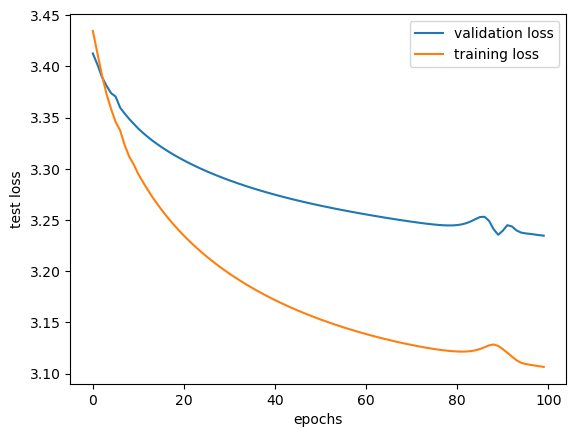

In [16]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [17]:
valid(train_loader, model, loss_fn, device=device)

Test Error: 
 Accuracy: 100.0%, Avg loss: 3.106620 



3.106620318823812

In [18]:
valid(test_loader, model, loss_fn, device=device)

Test Error: 
 Accuracy: 83.8%, Avg loss: 3.234778 



3.234778021135901

### 2. Multi Layer Perceptron

In [19]:
from utils.models import MLP
from utils.transforms import Compose, Flatten, ToTensor 
from torch.utils.data import random_split, DataLoader 

# Training parameters
batch_size = 32
lr = 0.01
epochs = 100

# data 
transform = Compose([Flatten(), ToTensor()])
data.transform = transform 
trainset, testset = random_split(data, [0.8, 0.2])

train_loader = DataLoader(trainset, batch_size=batch_size)
test_loader  = DataLoader(testset, batch_size=batch_size)

# model
sample = data[0]['eeg']
input_size = sample.shape[0]
model = MLP(input_size).to(device)

print('Number of parameters: ', sum([x.reshape(-1).shape[0] for x in model.parameters()]))

Number of parameters:  10256769


In [20]:
model.parameters

<bound method Module.parameters of MLP(
  (input): Sequential(
    (0): Linear(in_features=80000, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

In [21]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device, clip=0.25))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------


/tmp/ipykernel_16570/1075460736.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)


Test Error: 
 Accuracy: 43.6%, Avg loss: 3.830759 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.830613 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.830408 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.830253 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.830033 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.829819 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.829568 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.829594 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.829244 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 43.6%, Avg loss: 3.828654 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 56.4%, Avg loss: 3.827898 

Epoch 12
-----------------

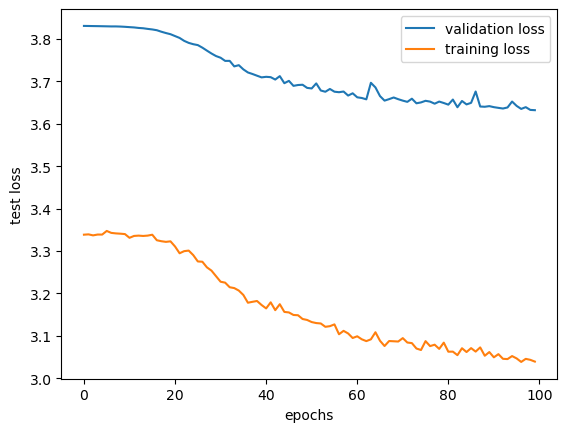

In [22]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [23]:
valid(train_loader, model, loss_fn, device=device)

Test Error: 
 Accuracy: 98.9%, Avg loss: 2.995060 



2.995060145222204

In [24]:
valid(test_loader, model, loss_fn, device=device)

Test Error: 
 Accuracy: 83.8%, Avg loss: 3.632038 



3.632038083850828

### 3. Convolutional Model

In [25]:
from utils.models import CNN
from utils.transforms import ToTensor, Compose
from torch.utils.data import random_split, DataLoader

# Training parameters
batch_size = 32
lr = 0.005
epochs = 100

# data 
transform = Compose([ToTensor()])
data.transform = transform
trainset, testset = random_split(data, [0.8, 0.2])

train_loader = DataLoader(trainset, batch_size=32)
test_loader = DataLoader(testset, batch_size=32)

# model
sample = data[0]['eeg']
n_channels = sample.shape[0]
n_kernels = 8

model = CNN(n_channels, n_kernels).to(device)
#model.init_weights()
print(sum([x.reshape(-1).shape[0] for x in model.parameters()]))

41601


In [26]:
model.parameters

<bound method Module.parameters of CNN(
  (conv1d): Sequential(
    (0): Conv1d(1, 8, kernel_size=(32,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
  )
  (encode): Sequential(
    (0): Linear(in_features=1024, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (pool): AvgPool2d(kernel_size=(1, 128), stride=(1, 64), padding=0)
  (output): Sequential(
    (0): Linear(in_features=320, out_features=1, bias=True)
    (1): Sigmoid()
  )
)>

In [27]:
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

tra_loss = []
val_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tra_loss.append(train(train_loader, model, loss_fn, optimizer, device=device, clip=0.1))
    val_loss.append(valid(test_loader, model, loss_fn, device=device))

print('Done!')

Epoch 1
-------------------------------


/tmp/ipykernel_16570/1075460736.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), clip)


Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697969 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697966 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697957 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697941 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697905 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697760 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.697434 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 54.7%, Avg loss: 3.696587 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 56.4%, Avg loss: 3.693108 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 63.2%, Avg loss: 3.684523 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 59.8%, Avg loss: 3.668329 

Epoch 12
-----------------

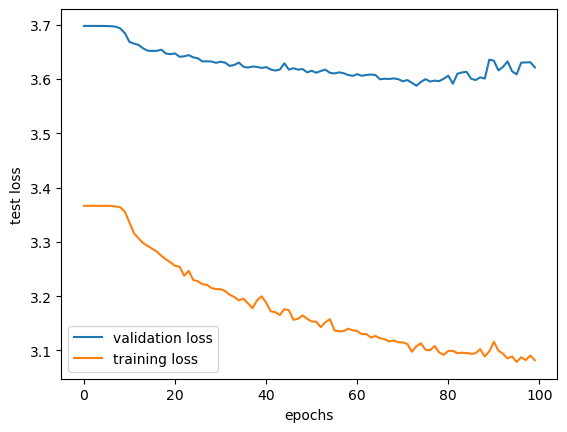

In [28]:
e = range(epochs)
plt.plot(e, val_loss, tra_loss)
plt.xlabel('epochs')
plt.ylabel('test loss')
plt.legend(['validation loss', 'training loss'])

In [29]:
import sys
sys.path.append('../')

from utils.dataset import EEGDataset
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


eeg_dir = Path('../EEGDataset/raw')
subjects = ['sub-01']

data = EEGDataset(eeg_dir, subjects)

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# Debug conv
from utils.models import CNN2, LIN
from utils.transforms import ToTensor, Compose, Flatten

# Training parameters
lr = 0.01
epochs = 300

# data 
transform = Compose([ToTensor()])
data.transform = transform
samples = [data[100], data[500]]

X = torch.stack([s['eeg'] for s in samples]).to(device)
y = torch.stack([s['label'] for s in samples]).to(device)

# model
n_channels = samples[0]['eeg'].shape[0]
n_kernels = 1

model = CNN2().to(device)

# loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# Training
losses = []
for _ in range(epochs):
    model.train()

    pred = model(X).squeeze()
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(model.parameters(), 0.25)   
    optimizer.step()

    losses.append(loss.item())


# Plot training loss
e = range(epochs)
plt.plot(e, losses)
plt.xlabel('epochs')
plt.ylabel('train loss')



NotADirectoryError: [Errno 20] Not a directory: '/home/admin/work/NetworkMachineLearning_2023/EEGDataset/electrode_coordinates.csv'

In [2]:
model.eval()
pred = model(X).squeeze()
loss = loss_fn(pred, y).item()
print(pred)
print(y)
print('loss: ', loss)
print('accuracy: ', ((pred>0.5) == y).type(torch.float).sum().item()/2)

tensor([0.9976, 0.0024], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([1., 0.], device='cuda:0')
loss:  0.002388337627053261
accuracy:  1.0
